# Instructions
You will submit an HTML document to Canvas as your final version.  

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.  

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.  

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise. The information collected includes:  

- **age**: Age of the patient
- **sex**: Sex of the patient
- **cp**: Chest Pain type
  - Value 0: asymptomatic
  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain
- **trtbps**: Resting blood pressure (in mm Hg)
- **chol**: Cholesterol in mg/dl fetched via BMI sensor
- **restecg**: Resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **thalach**: Maximum heart rate achieved during exercise
- **output**: The doctor’s diagnosis of whether the patient is at risk for a heart attack
  - 0 = not at risk of heart attack
  - 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.


In [45]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, cohen_kappa_score, classification_report
from plotnine import *
from statsmodels.api import Logit

In [7]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [6]:
print(ha.describe())

              age         sex          cp      trtbps        chol     restecg  \
count  273.000000  273.000000  273.000000  273.000000  273.000000  273.000000   
mean    54.347985    0.673993    0.974359  132.098901  246.860806    0.538462   
std      9.163134    0.469611    1.030456   17.700358   52.569726    0.528059   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.000000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    1.000000  130.000000  240.000000    1.000000   
75%     61.000000    1.000000    2.000000  140.000000  275.000000    1.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    2.000000   

          thalach      output  
count  273.000000  273.000000  
mean   149.446886    0.534799  
std     23.240707    0.499704  
min     71.000000    0.000000  
25%    133.000000    0.000000  
50%    152.000000    1.000000  
75%    166.000000    1.000000  
max    202.000

The dataset consists of 273 observations. The patients’ ages range from 29 to 77, with an average age in the mid-50s. There is a slight imbalance in the sex variable, and the target variable (output) indicates that roughly half of the patients are at risk of a heart attack. Cholesterol and resting blood pressure show a wide range, suggesting variability in patient health, and some features may contain potential outliers (e.g., cholesterol). Chest pain type and ECG results seem to be evenly distributed across their respective categories. Overall, the dataset seems well-structured, with no missing values, and is ready for further exploration and modeling.

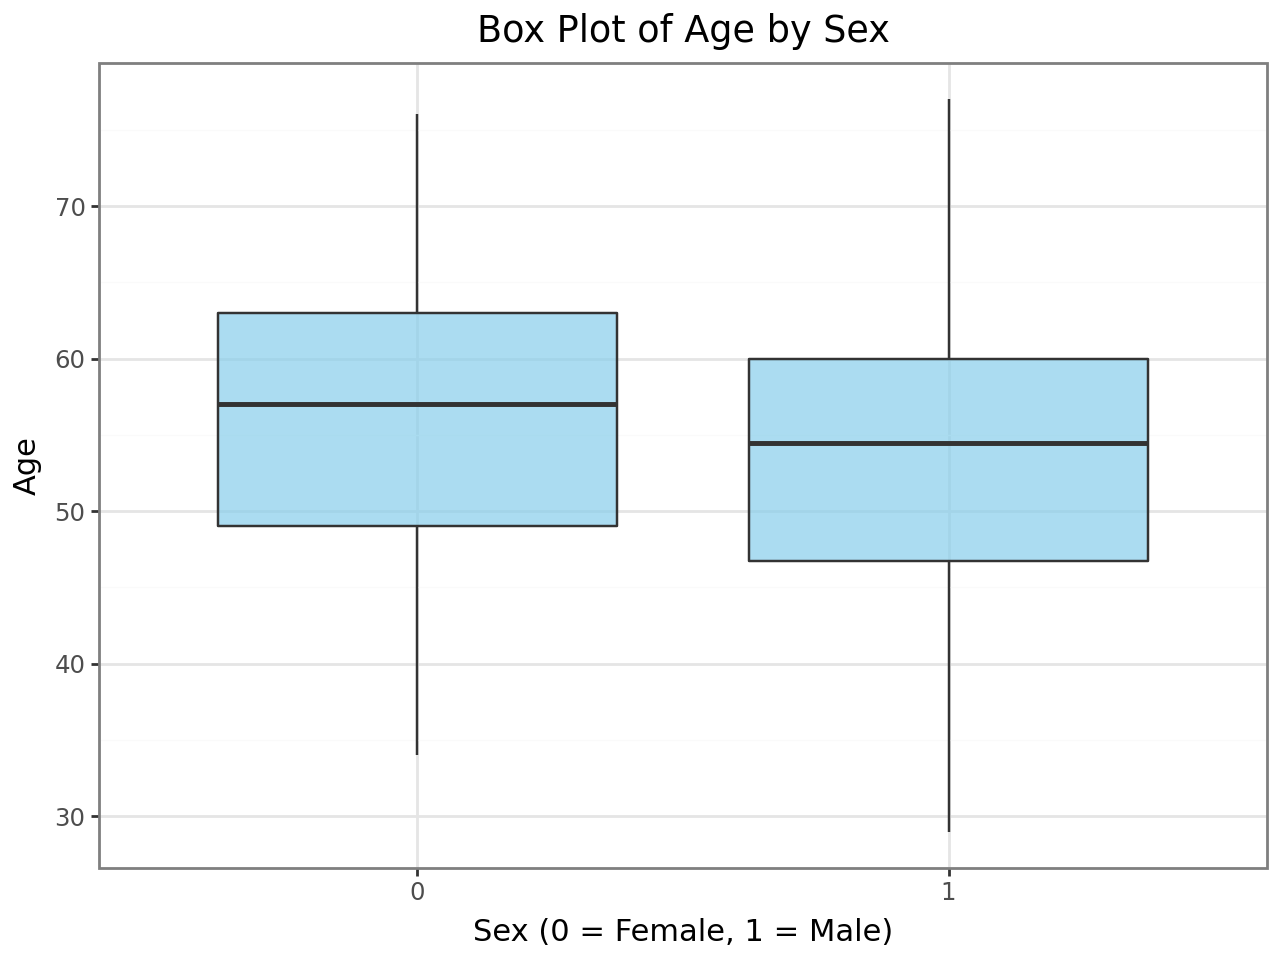

In [21]:
(ggplot(ha, aes(x='factor(sex)', y='age')) +
    geom_boxplot(fill='skyblue', alpha=0.7) +
    labs(title="Box Plot of Age by Sex", 
         x="Sex (0 = Female, 1 = Male)",
         y="Age") +
    theme_bw()
)

The box plot displays the age distribution for males (sex = 1) and females (sex = 0). Both groups show a similar range of ages, and the interquartile range (IQR) for both groups is similar, indicating similar variability in age. The median age appears slightly higher for females, suggesting they might be older on average in this dataset. There do not appear to be significant outliers in either group based on this plot.

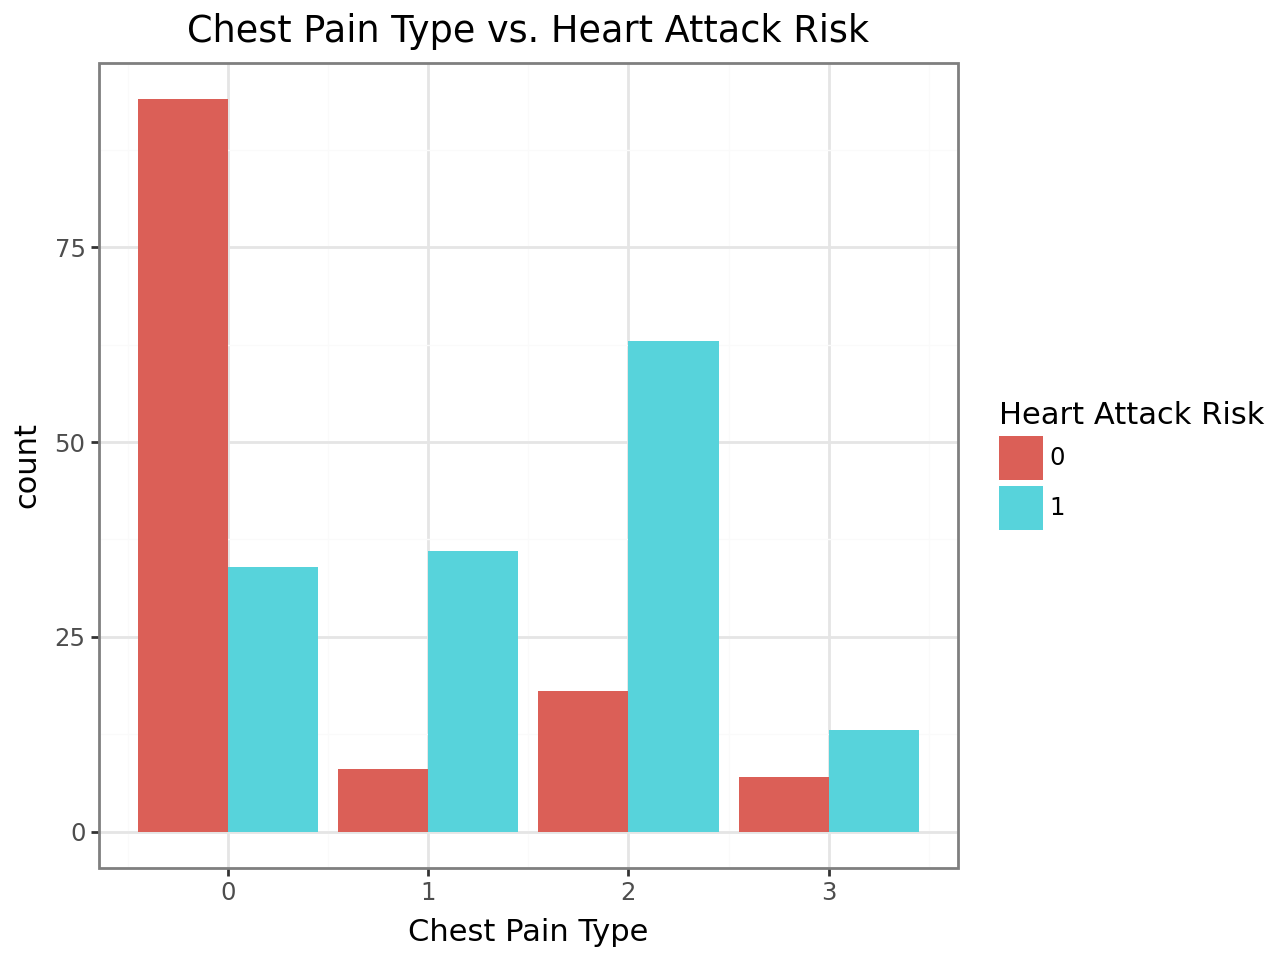

In [ ]:
(ggplot(ha, aes(x='cp', fill='factor(output)')) + \
    geom_bar(position='dodge') + \
    labs(title="Chest Pain Type vs. Heart Attack Risk",
         x="Chest Pain Type",
         fill="Heart Attack Risk") + \
    theme_bw()
)

This bar plot shows the relationship between chest pain type (cp) and heart attack risk (output). Patients with asymptomatic chest pain (type 0) have the highest counts, and a majority of them are at no risk (output = 0). In contrast, for chest pain types 1, 2, and 3 (typical angina, atypical angina, and non-anginal pain), the majority of patients are at risk of a heart attack (output = 1). The trend suggests that the likelihood of heart attack risk is higher for patients with atypical or less common chest pain types. Chest pain type may be a strong predictor of heart attack risk.

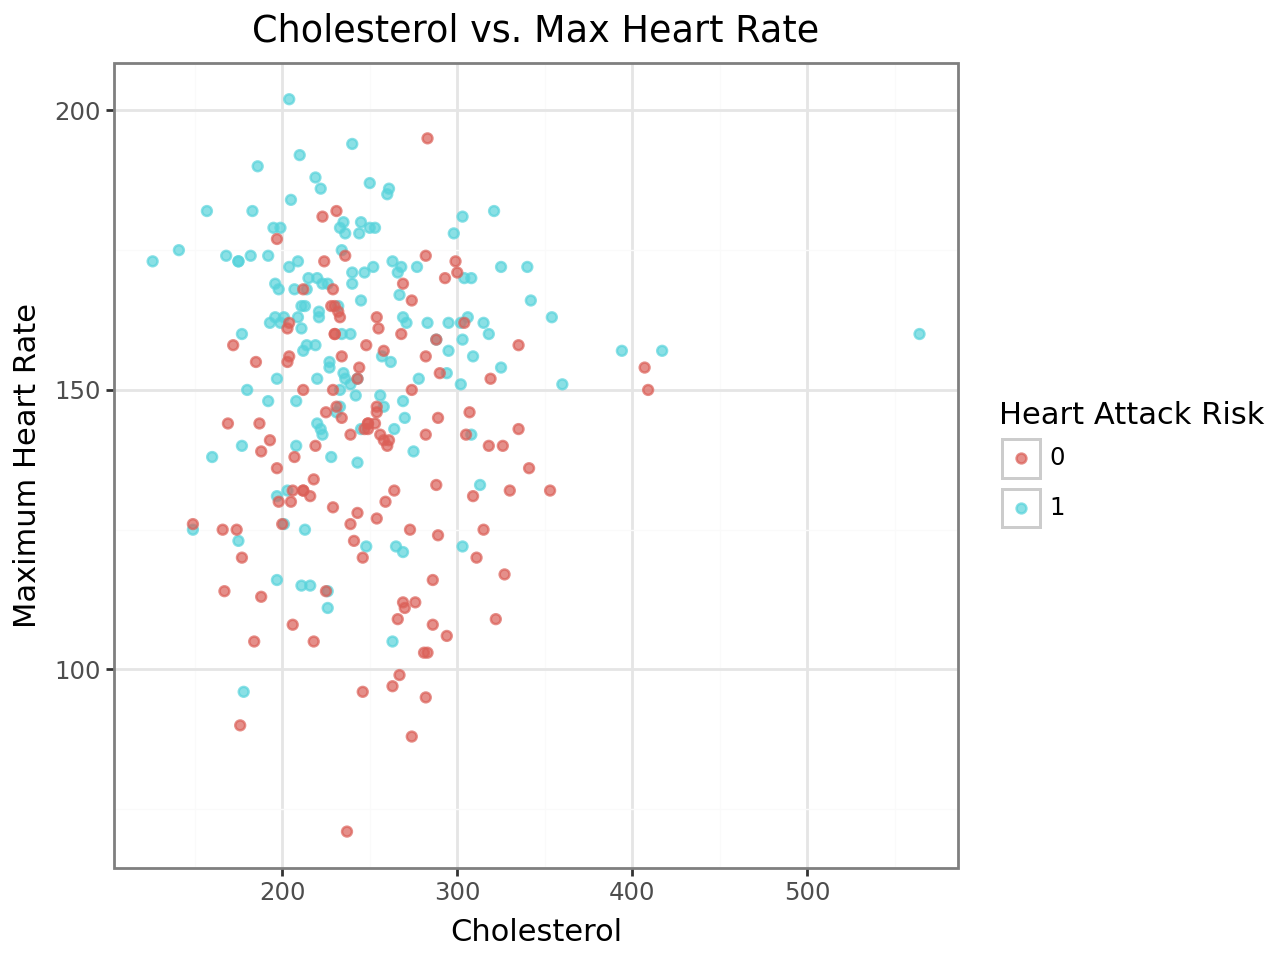

In [16]:
(ggplot(ha, aes(x='chol', y='thalach', color='factor(output)')) +
    geom_point(alpha=0.7) +
    labs(title="Cholesterol vs. Max Heart Rate",
         x="Cholesterol",
         y="Maximum Heart Rate",
         color="Heart Attack Risk") +
    theme_bw()
)

Looking at this scatterplot, there does not appear to be a clear linear relationship between cholesterol and maximum heart rate. Patients at both risk levels (output = 0 and output = 1) are distributed across the range of cholesterol values, although higher cholesterol values (above 400 mg/dL) are rare. Similarly, heart attack risk seems to occur across all ranges of maximum heart rate, with no strong clustering. This suggests that cholesterol and maximum heart rate individually may not be strong predictors of heart attack risk, but they could still provide valuable information in combination with other variables.

In [ ]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']

# Calculate correlation matrix for predictors
correlation_matrix = X.corr()
print(correlation_matrix)

              age       sex        cp    trtbps      chol   restecg   thalach
age      1.000000 -0.100841 -0.096004  0.308021  0.220130 -0.100412 -0.403412
sex     -0.100841  1.000000 -0.062922 -0.054932 -0.208995 -0.090094 -0.036794
cp      -0.096004 -0.062922  1.000000  0.059199 -0.079811  0.059249  0.308125
trtbps   0.308021 -0.054932  0.059199  1.000000  0.147251 -0.137880 -0.056877
chol     0.220130 -0.208995 -0.079811  0.147251  1.000000 -0.131053 -0.012705
restecg -0.100412 -0.090094  0.059249 -0.137880 -0.131053  1.000000  0.048922
thalach -0.403412 -0.036794  0.308125 -0.056877 -0.012705  0.048922  1.000000


Most of the predictors show weak correlations with each other, as most values are close to 0. This suggests there isn’t strong multicollinearity in the dataset, which is good for modeling.

In [32]:
correlations_with_target = X.corrwith(y)
print(correlations_with_target)

age       -0.239918
sex       -0.303982
cp         0.419420
trtbps    -0.136519
chol      -0.078189
restecg    0.144686
thalach    0.413995
dtype: float64


The correlation values show that cp (0.419) and thalach (0.414) have the strongest positive relationships with the target variable output, making them likely important predictors. Meanwhile, sex (-0.304) and age (-0.240) show moderate negative correlations with the target, suggesting some predictive potential. It appears that chol (-0.078) and trtbps (-0.137) have the weakest correlations, indicating they may not significantly contribute to predicting the outcome.

# Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on ROC AUC for predicting the target variable.
- Report the (cross-validated!) ROC AUC metric.
- Fit the final model.
- Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.
- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [56]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Define ColumnTransformer
knn_ct = ColumnTransformer(
    [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"), ["sex", "cp"]),
      ("standardize", StandardScaler(), ["age", "trtbps", "thalach"])
    ],
    remainder = "drop"
)

# Define KNN pipeline
knn_pipeline = Pipeline([
    ("preprocessor", knn_ct),
    ("classifier", KNeighborsClassifier())]
)

param_grid = {'classifier__n_neighbors': range(1, 21)}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['classifier__n_neighbors']
best_score = grid_search.best_score_
print(f"Best k: {best_k}")
print(f"Best cross-validated ROC AUC: {best_score:.4f}")

Best k: 15
Best cross-validated ROC AUC: 0.8072


I started with a KNN model using all of the predictors, optimizing the number of neighbors (k) using a grid search and cross-validation based on the ROC AUC metric. The best k was found to be 19, with a cross-validated ROC AUC of 0.7760. To improve model performance, I tested removing individual predictors and combinations of predictors based on their correlation with the target variable (output) and contribution to ROC AUC. Features with low correlation to the target, such as **chol** (-0.078) and **restecg** (0.144), were identified as potential candidates for removal. The final model uses the following 5 predictors: **age**, **sex**, **cp**, **trtbps**, **thalach**. These features, paired with the optimal k of 15, provided the highest ROC AUC of 0.8072.

In [57]:
# Define the final pipeline
final_knn_pipeline = Pipeline([
    ("preprocessor", knn_ct),
    ("classifier", KNeighborsClassifier(n_neighbors=best_k))]
)

# Fit the final pipeline
final_knn_pipeline.fit(X_train, y_train)

# Predict classes on the test set
y_pred = final_knn_pipeline.predict(X_test)

# Generate and display the confusion matrix
knn_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(knn_cm)

# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[25  8]
 [10 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        33
           1       0.76      0.72      0.74        36

    accuracy                           0.74        69
   macro avg       0.74      0.74      0.74        69
weighted avg       0.74      0.74      0.74        69



The confusion matrix and classification report show that the model performs with an overall accuracy of 74%. For the negative class (0 - not at risk of heart attack), the model achieves a precision of 71% and a recall of 76%, indicating that 71% of predicted negatives were correct, while 76% of actual negatives were correctly identified. For the positive class (1 - at risk of heart attack), the model achieves a precision of 76% and a recall of 72%, showing that 76% of predicted positives were correct, while 72% of actual positives were correctly identified. The F1-score is 0.74 for both classes. The confusion matrix shows that 25 true negatives, 26 true positives, 8 false positives, and 10 false negatives were observed. The model shows balanced performance overall but could be improved by reducing false negatives.

ROC AUC with all predictors: 0.7760
ROC AUC with all predictors except "chol": 0.8033
ROC AUC with all predictors except "trtbps": 0.7774
ROC AUC with all predictors except "restecg": 0.7907
ROC AUC with all predictors except "chol" and "trtbps": 0.7997
ROC AUC with all predictors except "chol" and "restecg": 0.8072
ROC AUC with all predictors except "chol", "trtbps", and "restecg": 0.8015

## Q2: Logistic Regression

In [59]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg_ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), ["sex", "cp"]),
        ("standardize", StandardScaler(), ["age", "chol", "trtbps", "thalach"]),
    ],
    remainder="drop"
)

# Define the pipeline
logreg_pipeline = Pipeline([
    ("preprocessor", logreg_ct),
    ("classifier", LogisticRegression(max_iter=1000))]
)

# Define the parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear']  # Solver compatible with L1 and L2
}

# Perform GridSearchCV
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and cross-validated ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated ROC AUC: {best_score:.4f}")

Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validated ROC AUC: 0.8595


Just like for KNN, I began building the Logistic Regression model using all predictors. The best model with all predictors achieved a cross-validated ROC AUC of 0.8567, using L1 regularization (penalty = 'l1'), a regularization strength of C = 10, and the liblinear solver. To refine the model, I repeated the same procedure I did for KNN, removing individual predictors and combinations of predictors. Removing **restecg** improved the ROC AUC to 0.8595. The final model excludes **restecg** and uses the predictors **age**, **sex**, **cp**, **trtbps**, **chol**, and **thalach**, achieving the highest cross-validated ROC AUC of 0.8595. This model also uses L1 regularization (penalty = 'l1'), a regularization strength of C = 10, and the liblinear solver.

ROC AUC with all predictors: 0.8567
ROC AUC with all predictors except "chol": 0.8484
ROC AUC with all predictors except "trtbps": 0.8436
ROC AUC with all predictors except "restecg": 0.8595
ROC AUC with all predictors except "chol" and "trtbps": 0.8410
ROC AUC with all predictors except "chol" and "restecg": 0.8509
ROC AUC with all predictors except "chol", "trtbps", and "restecg": 0.8453

In [60]:
# Define the final pipeline
final_logreg_pipeline = Pipeline([
    ("preprocessor", logreg_ct),
    ("classifier", LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000))]
)

# Fit the final pipeline
final_logreg_pipeline.fit(X_train, y_train)

# Predict classes on the test set
y_pred = final_logreg_pipeline.predict(X_test)

# Generate and display the confusion matrix
logreg_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(logreg_cm)

# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[25  8]
 [ 5 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.79      0.86      0.83        36

    accuracy                           0.81        69
   macro avg       0.81      0.81      0.81        69
weighted avg       0.81      0.81      0.81        69



The confusion matrix and classification report show that the Logistic Regression model performs with an overall accuracy of 81%. For the negative class (0 - not at risk of heart attack), the model achieves a precision of 83% and a recall of 76%, indicating that 83% of predicted negatives were correct, while 76% of actual negatives were correctly identified. For the positive class (1 - at risk of heart attack), the model achieves a precision of 79% and a recall of 86%, showing that 79% of predicted positives were correct, while 86% of actual positives were correctly identified. The F1-score is 0.79 for the negative class and 0.83 for the positive class. The confusion matrix shows that 25 true negatives, 31 true positives, 8 false positives, and 5 false negatives were observed. The model shows balanced performance overall and does a good job of identifying at-risk patients. However, reducing false negatives, where at-risk patients are incorrectly predicted as not at risk, could make the model even more effective.

In [64]:
# Extract coefficients and features
coefficients = final_logreg_pipeline.named_steps['classifier'].coef_.flatten()
features = logreg_ct.get_feature_names_out()
logreg_coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort by absolute value of coefficients
logreg_coef_df = logreg_coef_df.sort_values(by='Coefficient', key=abs, ascending=False) 
print("Feature Coefficients:")
print(logreg_coef_df)


Feature Coefficients:
                Feature  Coefficient
1         dummify__cp_1     2.714659
0        dummify__sex_1    -2.306828
3         dummify__cp_3     2.192488
2         dummify__cp_2     1.847921
7  standardize__thalach     0.836954
5     standardize__chol    -0.397433
6   standardize__trtbps    -0.383794
4      standardize__age    -0.162280


Interpretation of Coefficients:  

**cp_1 (Chest Pain Type 1 - Typical Angina):**  
   - Patients with typical angina have a much higher likelihood of being at risk of a heart attack compared to the reference group (cp_0 - asymptomatic chest pain), with a coefficient of **2.71**. This is the strongest positive predictor in the model.  

**cp_3 (Chest Pain Type 3 - Non-Anginal Pain):**  
   - Patients with non-anginal pain are more likely to be at risk compared to the asymptomatic group, with a coefficient of **2.19**, though the effect is smaller than cp_1.  

**cp_2 (Chest Pain Type 2 - Atypical Angina):**  
   - Atypical angina increases the likelihood of being at risk compared to the asymptomatic group, with a coefficient of **1.85**. The effect is weaker than cp_1 and cp_3.  

**sex_1 (Male):**  
   - Being male decreases the likelihood of being at risk of a heart attack compared to being female, with a coefficient of **-2.31**.  

**thalach (Maximum Heart Rate):**  
   - A 1-standard deviation increase in maximum heart rate is associated with a higher likelihood of being at risk of a heart attack, with a coefficient of **0.84**. This is the most influential numerical predictor.  

**chol (Cholesterol):**  
   - A 1-standard deviation increase in cholesterol slightly decreases the likelihood of being at risk, with a coefficient of **-0.39**. However, the impact is relatively small.  

**trtbps (Resting Blood Pressure):**  
   - A 1-standard deviation increase in resting blood pressure slightly decreases the likelihood of being at risk, with a coefficient of **-0.38**, indicating minimal influence.  

**age (Age):**  
   - A 1-standard deviation increase in age weakly decreases the likelihood of being at risk of a heart attack, with a coefficient of **-0.16**. This suggests that age may not be a strong predictor in this model.  

## Q3: Decision Trees

## Q4: Interpretation  
Which predictors were most important to predicting heart attack risk?

## Q5: ROC Curve  
Plot the ROC Curve for your three models above.

# Part Two: Metrics

Consider the following metrics:  

- **True Positive Rate** or **Recall** or **Sensitivity**  
  Of the observations that are truly Class A, how many were predicted to be Class A?  

- **Precision** or **Positive Predictive Value**  
  Of all the observations classified as Class A, how many of them were truly from Class A?  

- **True Negative Rate** or **Specificity** or **Negative Predictive Value**  
  Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

# Part Three: Discussion  
Suppose you have been hired by a hospital to create classification models for heart attack risk.  

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:  

- Which metric(s) you would use for model selection and why.  
- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.  
- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.  

## Q1  
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

## Q2  
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

## Q3  
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

## Q4  
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

# Part Four: Validation   

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.  

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.  

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.  

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?  

In [ ]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

# Part Five: Cohen’s Kappa  

Another common metric used in classification is Cohen’s Kappa.  

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?  

# Appendix and References  
- KNN: https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html  
- Logistic Regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html  

Generative AI Statement:  
In this lab, ChatGPT 4o was very helpful in simplifying and automating tasks, especially in Section 5. It made setting up combinations of predictors and interactions easier, saving time and ensuring I tested a wide range of models. During debugging, ChatGPT 4o provided clear explanations for error messages, which helped me fix issues with data processing and feature mismatches between training and test sets. It also guided me in writing a function to find the best model by automatically calculating R-squared and MSE values, based on code from previous steps. Overall, ChatGPT 4o improved the efficiency and accuracy of the project, helping me organize my code and explore the best models more effectively.